In [28]:
!pip3 install torch torchvision

In [0]:
import torch
import torchvision
import torchvision.datasets as tds
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import PIL
import json
import urllib

from torchvision import transforms
from torchvision import models

In [0]:
device = torch.device("cuda:0")

In [31]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])                           
])

data_train = tds.SVHN('./', 
                       transform = tfs,
                       download=True)

data_test = tds.SVHN('./', 
                      split='test', 
                      transform = tfs,
                      download=True)

Using downloaded and verified file: ./train_32x32.mat
Using downloaded and verified file: ./test_32x32.mat


In [0]:
batch_size = 64

validation_size = .2

data_size = data_train.data.shape[0]
split = int(np.floor(validation_size * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[:split], indices[split:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

Using downloaded and verified file: ./train_32x32.mat


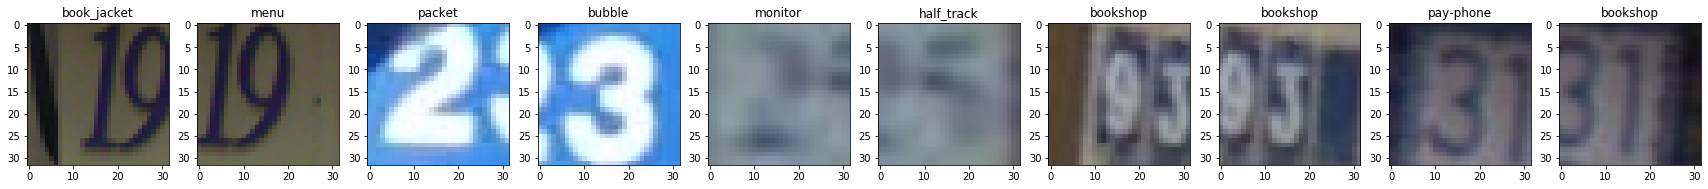

In [33]:
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    return { int(k): v[-1] for k, v in classes.items()}

def visualize(tensor_data, orig_data, model, classes, count=10):
  plt.figure(figsize=(count * 3, 3))
  for i, (X, y) in enumerate(tensor_data):
    if i == count:
      break
    plt.subplot(1, count, i + 1)

    img, _ = orig_data[i]
    x_gpu = X.to(device)

    prediction = model(torch.unsqueeze(x_gpu, 0))
    y_hat = torch.argmax(prediction, 1)
    class_index = int(y_hat)

    plt.title(classes[class_index])
    plt.imshow(img)

model = models.resnet18(pretrained=True)
model.type(torch.cuda.FloatTensor)
model.to(device)
model.eval()

classes = load_imagenet_classes()
visualize(data_train, tds.SVHN('./', download=True), model, classes)

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer,  scheduler=None, num_epochs=20):
  train_loss_history = []
  train_history = []
  val_loss_histroy = []
  val_histroy = []

  for i_epoch in range(num_epochs):
    model.train()

    train_loss_sum = 0
    correct_samples = 0
    all_samples = 0

    for i_step, (x, y) in enumerate(train_loader):
      x_gpu = x.to(device)
      y_gpu = y.to(device)
      prediction = model(x_gpu)
      step_loss = loss(prediction, y_gpu)
      optimizer.zero_grad()
      step_loss.backward()
      optimizer.step()

      y_hat = torch.argmax(prediction, 1)
      correct_samples += float(torch.sum(y_hat == y_gpu))
      all_samples += y.shape[0]
      train_loss_sum += step_loss
    
    train_loss = train_loss_sum / i_step
    train_accuracy = correct_samples / all_samples
    val_loss, val_accuracy = compute_accuracy(model, val_loader, loss)
    if scheduler:
      scheduler.step(val_loss)

    train_loss_history.append(train_loss)
    val_loss_histroy.append(val_loss)
    train_history.append(train_accuracy)
    val_histroy.append(val_accuracy)

    print('Epoch num: %f, Train loss: %f, Val loss: %f, Train accuracy: %f, Validation accuracy: %f' % (i_epoch, train_loss, val_loss, train_accuracy, val_accuracy))
  
  return train_loss_history, val_loss, train_history, val_histroy

def compute_accuracy(model, loader, loss):
  model.eval()

  correct_samples = 0
  all_samples = 0
  loss_sum = 0

  for i_step, (x, y) in enumerate(loader):
    x_gpu = x.to(device)
    y_gpu = y.to(device)

    prediction = model(x_gpu)
    y_hat = torch.argmax(prediction, 1)

    loss_val = loss(prediction, y_gpu)
    loss_sum += float(loss_val)

    correct_samples += float(torch.sum(y_hat == y_gpu))
    all_samples += y.shape[0]
    
  avg_loss = loss_sum / i_step
  accuracy = correct_samples / all_samples

  return avg_loss, accuracy

In [0]:
model = models.resnet18(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

model.type(torch.cuda.FloatTensor)
model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)

In [49]:
train_loss_history, val_loss, train_history, val_histroy = train_model(model, train_loader, val_loader, loss, optimizer, scheduler, 30)

Epoch num: 0.000000, Train loss: 0.234481, Val loss: 0.404998, Train accuracy: 0.930790, Validation accuracy: 0.881923
Epoch num: 1.000000, Train loss: 0.228763, Val loss: 0.379147, Train accuracy: 0.932291, Validation accuracy: 0.890148


KeyboardInterrupt: ignored

In [37]:
test_loader = torch.utils.data.DataLoader(data_test)
_, test_accuracy = compute_accuracy(model, test_loader, loss)
print('Test accuracy: %f' % (test_accuracy))

Test accuracy: 0.915297


In [0]:
model_last = models.resnet18(pretrained=True)

for param in model_last.parameters():
    param.requires_grad = False

old_fc = model_last.fc
model_last.fc = nn.Linear(old_fc.in_features, 10)

model_last.type(torch.cuda.FloatTensor)
model_last.to(device)

parameters = model_last.fc.parameters()

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(parameters, lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)

In [51]:
train_loss_history, val_loss, train_history, val_histroy = train_model(model_last, train_loader, val_loader, loss, optimizer, scheduler, 30)

Epoch num: 0.000000, Train loss: 2.204170, Val loss: 2.085341, Train accuracy: 0.230223, Validation accuracy: 0.270450
Epoch num: 1.000000, Train loss: 2.074159, Val loss: 2.072629, Train accuracy: 0.272405, Validation accuracy: 0.277258
Epoch num: 2.000000, Train loss: 2.054782, Val loss: 2.044385, Train accuracy: 0.281687, Validation accuracy: 0.287667
Epoch num: 3.000000, Train loss: 2.038094, Val loss: 2.049640, Train accuracy: 0.287830, Validation accuracy: 0.289748
Epoch num: 4.000000, Train loss: 2.020159, Val loss: 2.029284, Train accuracy: 0.293768, Validation accuracy: 0.292427
Epoch num: 5.000000, Train loss: 2.022080, Val loss: 2.022994, Train accuracy: 0.296362, Validation accuracy: 0.298775
Epoch num: 6.000000, Train loss: 2.016235, Val loss: 2.026927, Train accuracy: 0.302027, Validation accuracy: 0.297802
Epoch num: 7.000000, Train loss: 2.023051, Val loss: 2.037034, Train accuracy: 0.300662, Validation accuracy: 0.287206
Epoch num: 8.000000, Train loss: 2.015801, Val l

In [44]:
test_loader = torch.utils.data.DataLoader(data_test)
_, test_accuracy = compute_accuracy(model_last, test_loader, loss)
print('Test accuracy: %f' % (test_accuracy))

Test accuracy: 0.301129
